In [276]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [277]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os


import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
#from RAdam import radam

import cv2
import matplotlib.image as mpimg
import numpy as np
import csv
import requests
import zipfile
import time
import pandas as pd
import ntpath

# Create Data Frame

In [278]:
datadir = '/content/drive/MyDrive/trial'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df1 = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
df1.head()

<ipython-input-278-0029ae7bb969>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_044.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_044.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_044.jpg,0.0,0.000000,0.0,0.000025
1,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_111.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_111.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_111.jpg,0.0,0.000000,0.0,0.000015
2,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_187.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_187.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_187.jpg,0.0,0.000000,0.0,0.000003
3,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_257.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_257.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_257.jpg,0.0,0.000000,0.0,0.000007
4,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_325.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_325.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_325.jpg,0.0,0.159388,0.0,0.050384


# Remove the prefix part throughout the dataset

In [279]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

df1['center'] = df1['center'].apply(path_leaf)
df1['left'] = df1['left'].apply(path_leaf)
df1['right'] = df1['right'].apply(path_leaf)
df1.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_09_28_12_09_38_044.jpg,left_2023_09_28_12_09_38_044.jpg,right_2023_09_28_12_09_38_044.jpg,0.0,0.000000,0.0,0.000025
1,center_2023_09_28_12_09_38_111.jpg,left_2023_09_28_12_09_38_111.jpg,right_2023_09_28_12_09_38_111.jpg,0.0,0.000000,0.0,0.000015
2,center_2023_09_28_12_09_38_187.jpg,left_2023_09_28_12_09_38_187.jpg,right_2023_09_28_12_09_38_187.jpg,0.0,0.000000,0.0,0.000003
3,center_2023_09_28_12_09_38_257.jpg,left_2023_09_28_12_09_38_257.jpg,right_2023_09_28_12_09_38_257.jpg,0.0,0.000000,0.0,0.000007
4,center_2023_09_28_12_09_38_325.jpg,left_2023_09_28_12_09_38_325.jpg,right_2023_09_28_12_09_38_325.jpg,0.0,0.159388,0.0,0.050384


# Create Data Frame Containing center and steering only

In [280]:
df = df1.iloc[:, [0,3]]

In [281]:
df.head()

,center,steering
0,center_2023_09_28_12_09_38_044.jpg,0.0
1,center_2023_09_28_12_09_38_111.jpg,0.0
2,center_2023_09_28_12_09_38_187.jpg,0.0
3,center_2023_09_28_12_09_38_257.jpg,0.0
4,center_2023_09_28_12_09_38_325.jpg,0.0


# Image Visualization

In [ ]:
rand_image = df['Center'][100]
rand_image = npimg.imread(os.path.join('/content/drive/MyDrive/trial/IMG', rand_image.strip()))

# distribution of the steering wheel angle values

In [ ]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


Conclusion : Most of the time the car is driving straight meaning there is bias so i will need to shuffle the dataset.

# Image Preprocessing

In [282]:
def load_image(image_file):
    """
    Load image from File
    """
    data_dir_img='/content/drive/MyDrive/trial/IMG'
    return mpimg.imread(os.path.join(data_dir_img, image_file.strip()))


In [283]:
def crop(image):
    """
    Crop the image
    """
    return image[60:135,:,:]  # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (200, 66), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    #img=img/255
    return image



# Image Augmentation

In [284]:
def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle
def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [285]:
def augument(center,steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    """
    image = load_image(center)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_brightness(image)
    return image, steering_angle


# Create a CustomDataset

In [286]:
class CustomDataset(data.Dataset):

    def __init__(self,df, image_dir, transform = None):
        self.df=df
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, index):
        center= self.df["center"][index]
        steering_angle = float(self.df["steering"][index])

        if np.random.rand() < 0.5:
            image, steering_angle = augument(center,steering_angle)
        else:
            image = load_image(center)

        image = preprocess(image)

        if self.transform is not None:
            image = self.transform(image)

        return image, steering_angle

    def __len__(self):
        return len(self.df)

# Data Loader

In [ ]:
batch_size = 128
num_epochs = 30
validation_split = 0.20
shuffle_dataset = True
random_seed = 42
num_workers = 4

In [287]:
print("Initializing Datasets and Dataloaders...")
# Apply some transformations
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
#Create a dataset object
dataset = CustomDataset(df,'/content/drive/MyDrive/trial/IMG', transformations)
dataset_size = len(dataset)
# Creating data indices for training and validation splits
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
#Shuffle data to avoid bias
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)

data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**First Approach**


1.  We add a Convolutional layer with 3 filters kernel_size= 5x5 use Elu activation function stride =2
2.  We add a Maxpooling
3.  We add a second convolutional layer of 24 filters of 5x5 kernel size, with stride 2x2 and elu activation function.
4.  We add a second convolutional layer of 36 filters of 5x5 kernel size, with stride 2x2 and elu activation function.
5. We add 3 FC layers and a prodoupt in between.




In [288]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [289]:
class DriverNet(nn.Module):

  def __init__(self):
        super(DriverNet, self).__init__()


        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Flatten()

        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*1*10, out_features=100),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=1)
        )
  def forward(self, input):
      input = input.view(input.size(0), 3, 66, 200)
      output = self.conv_layers(input)
      output = output.view(output.size(0), -1)
      output = self.linear_layers(output)
      return output

In [290]:
model_ft = DriverNet()

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)
#optimizer_ft = optim.SGD(params_to_update, lr = 0.0001)
# optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)

Params to learn:
	 conv_layers.0.weight
	 conv_layers.0.bias
	 conv_layers.3.weight
	 conv_layers.3.bias
	 conv_layers.5.weight
	 conv_layers.5.bias
	 linear_layers.0.weight
	 linear_layers.0.bias
	 linear_layers.3.weight
	 linear_layers.3.bias
	 linear_layers.5.weight
	 linear_layers.5.bias


In [291]:
def toDevice(data, device):

  return data.float().to(device)

# Train Model

In [292]:
def toDevice(data, device):

  return data.float().to(device)
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    epoch_number, train_losses, val_losses,  = [], [], []
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_number.append(epoch)
        # Each epoch has a training and validation phase
        # Training loop
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels in dataloaders['train']:
          #print(inputs)
          #print(labels)
          inputs = toDevice(inputs, device)
          labels = toDevice(labels, device)

          optimizer.zero_grad()
          # Generate predictions
          out = model(inputs)
          #print(out)
          # Calculate loss
          loss = criterion(out, labels.unsqueeze(1))
          # Backpropagation
          loss.backward()
          # Update model parameters
          optimizer.step()

          train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
          for inputs, labels in dataloaders['val']:
            inputs = toDevice(inputs, device)
            labels = toDevice(labels, device)
            # Generate predictions
            out = model(inputs)
            # Calculate loss
            loss = criterion(out, labels.unsqueeze(1))
            #print(labels.unsqueeze(1))

            val_loss += loss.item()

        # Average validation loss
        train_loss = train_loss / len(dataloaders['train'])
        val_loss = val_loss / len(dataloaders['val'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(val_loss))

        # If the validation loss is at a minimum
        if val_loss < best_loss:
          # Save the model
          torch.save(model, 'model.h5')
          best_loss = val_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lead val Loss: {:4f}'.format(best_loss))

    #creating dataframe and record all the losses and accuracies at each epoch
    log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
    log_frame["Epoch"] = epoch_number
    log_frame["Train Loss"] = train_losses
    log_frame["Test Loss"] = val_losses
    log_frame.to_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"), index = False)

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [293]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [294]:
criterion = nn.MSELoss()

# Train and evaluate
model_ft = train_model(model_ft, data_loader_dict, criterion, optimizer_ft, num_epochs=num_epochs)


Epoch 0/29
----------
Train Loss: 0.0314
Val Loss: 0.0276
Epoch 1/29
----------
Train Loss: 0.0295
Val Loss: 0.0281
Epoch 2/29
----------
Train Loss: 0.0290
Val Loss: 0.0273
Epoch 3/29
----------
Train Loss: 0.0292
Val Loss: 0.0283
Epoch 4/29
----------
Train Loss: 0.0276
Val Loss: 0.0279
Epoch 5/29
----------
Train Loss: 0.0271
Val Loss: 0.0266
Epoch 6/29
----------
Train Loss: 0.0283
Val Loss: 0.0269
Epoch 7/29
----------
Train Loss: 0.0267
Val Loss: 0.0257
Epoch 8/29
----------
Train Loss: 0.0262
Val Loss: 0.0256
Epoch 9/29
----------
Train Loss: 0.0284
Val Loss: 0.0261
Epoch 10/29
----------
Train Loss: 0.0262
Val Loss: 0.0262
Epoch 11/29
----------
Train Loss: 0.0248
Val Loss: 0.0257
Epoch 12/29
----------
Train Loss: 0.0245
Val Loss: 0.0251
Epoch 13/29
----------
Train Loss: 0.0242
Val Loss: 0.0259
Epoch 14/29
----------
Train Loss: 0.0253
Val Loss: 0.0242
Epoch 15/29
----------
Train Loss: 0.0240
Val Loss: 0.0252
Epoch 16/29
----------
Train Loss: 0.0227
Val Loss: 0.0233
Epoch 1

# Results

In [295]:
frame = pd.read_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"))
frame

,Epoch,Train Loss,Test Loss
0,0,0.031367,0.027617
1,1,0.029513,0.028088
2,2,0.028968,0.027304
3,3,0.029153,0.028320
4,4,0.027649,0.027858
5,5,0.027139,0.026587
6,6,0.028282,0.026874
7,7,0.026737,0.025677
8,8,0.026193,0.025630
9,9,0.028430,0.026067


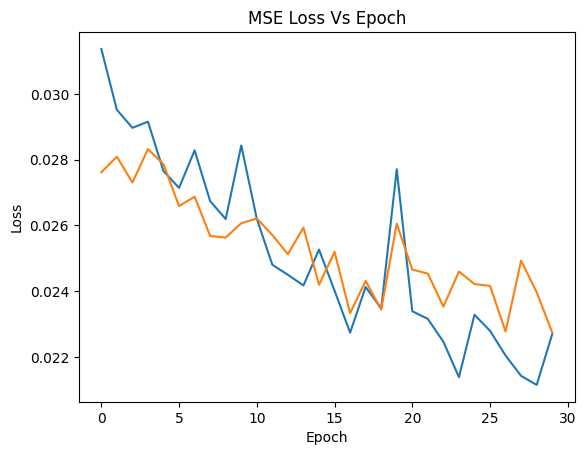

In [296]:
from matplotlib import pyplot as plt
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join("/content/drive/MyDrive/trial", "log2.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])


plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('MSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

# Second Approach

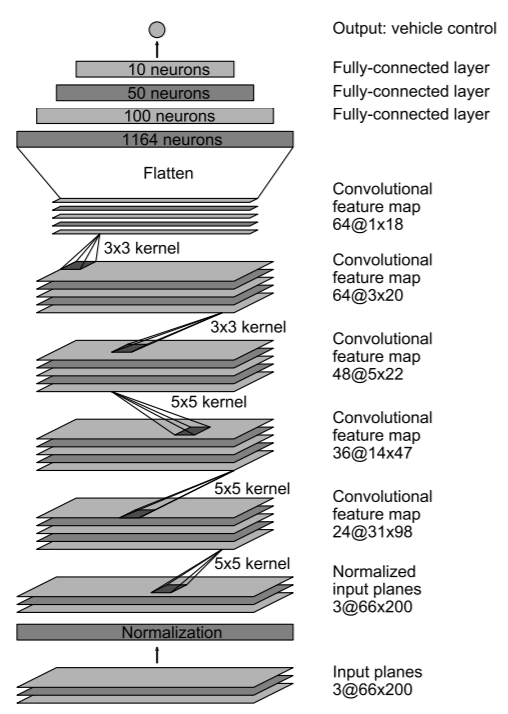

In [308]:
batch_size = 128
num_epochs = 39
validation_split = 0.20
shuffle_dataset = True
random_seed = 42
num_workers = 4

In [309]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [310]:
class DriverNet(nn.Module):

  def __init__(self):
        super(DriverNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(p=0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*1*18, out_features=100),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=10),
            nn.ELU(),
            nn.Linear(in_features=10, out_features=1)
        )


  def forward(self, input):
      input = input.view(input.size(0), 3, 66, 200)
      output = self.conv_layers(input)
      output = output.view(output.size(0), -1)
      output = self.linear_layers(output)
      return output


# Observe Paramters to be optimized

In [311]:
model_ft = DriverNet()

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)
optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)


Params to learn:
	 conv_layers.0.weight
	 conv_layers.0.bias
	 conv_layers.2.weight
	 conv_layers.2.bias
	 conv_layers.4.weight
	 conv_layers.4.bias
	 conv_layers.6.weight
	 conv_layers.6.bias
	 conv_layers.8.weight
	 conv_layers.8.bias
	 linear_layers.0.weight
	 linear_layers.0.bias
	 linear_layers.3.weight
	 linear_layers.3.bias
	 linear_layers.5.weight
	 linear_layers.5.bias
	 linear_layers.7.weight
	 linear_layers.7.bias


In [312]:
def toDevice(data, device):

  return data.float().to(device)

In [313]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    epoch_number, train_losses, val_losses,  = [], [], []
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_number.append(epoch)
        # Each epoch has a training and validation phase
        # Training loop
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels in dataloaders['train']:
          #print(inputs)
          #print(labels)
          inputs = toDevice(inputs, device)
          labels = toDevice(labels, device)

          optimizer.zero_grad()
          # Generate predictions
          out = model(inputs)
          #print(out)
          # Calculate loss
          loss = criterion(out, labels.unsqueeze(1))
          # Backpropagation
          loss.backward()
          # Update model parameters
          optimizer.step()

          train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
          for inputs, labels in dataloaders['val']:
            inputs = toDevice(inputs, device)
            labels = toDevice(labels, device)
            # Generate predictions
            out = model(inputs)
            # Calculate loss
            loss = criterion(out, labels.unsqueeze(1))
            #print(labels.unsqueeze(1))

            val_loss += loss.item()

        # Average validation loss
        train_loss = train_loss / len(dataloaders['train'])
        val_loss = val_loss / len(dataloaders['val'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(val_loss))

        # If the validation loss is at a minimum
        if val_loss < best_loss:
          # Save the model
          torch.save(model, 'model.h5')
          best_loss = val_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lead val Loss: {:4f}'.format(best_loss))

    #creating dataframe and record all the losses and accuracies at each epoch
    log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
    log_frame["Epoch"] = epoch_number
    log_frame["Train Loss"] = train_losses
    log_frame["Test Loss"] = val_losses
    log_frame.to_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"), index = False)

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [314]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [315]:
criterion = nn.MSELoss()

# Train and evaluate
model_ft = train_model(model_ft, data_loader_dict, criterion, optimizer_ft, num_epochs=num_epochs)


Epoch 0/38
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.0488
Val Loss: 0.0352
Epoch 1/38
----------
Train Loss: 0.0338
Val Loss: 0.0312
Epoch 2/38
----------
Train Loss: 0.0316
Val Loss: 0.0294
Epoch 3/38
----------
Train Loss: 0.0313
Val Loss: 0.0295
Epoch 4/38
----------
Train Loss: 0.0319
Val Loss: 0.0294
Epoch 5/38
----------
Train Loss: 0.0302
Val Loss: 0.0286
Epoch 6/38
----------
Train Loss: 0.0291
Val Loss: 0.0283
Epoch 7/38
----------
Train Loss: 0.0326
Val Loss: 0.0291
Epoch 8/38
----------
Train Loss: 0.0294
Val Loss: 0.0284
Epoch 9/38
----------
Train Loss: 0.0297
Val Loss: 0.0280
Epoch 10/38
----------
Train Loss: 0.0282
Val Loss: 0.0284
Epoch 11/38
----------
Train Loss: 0.0282
Val Loss: 0.0280
Epoch 12/38
----------
Train Loss: 0.0296
Val Loss: 0.0282
Epoch 13/38
----------
Train Loss: 0.0288
Val Loss: 0.0272
Epoch 14/38
----------
Train Loss: 0.0294
Val Loss: 0.0268
Epoch 15/38
----------
Train Loss: 0.0278
Val Loss: 0.0277
Epoch 16/38
----------
Train Loss: 0.0295
Val Loss: 0.0267
Epoch 17/38
----------
Train 

In [318]:
frame = pd.read_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"))
frame

,Epoch,Train Loss,Test Loss
0,0,0.048846,0.035170
1,1,0.033808,0.031152
2,2,0.031584,0.029351
3,3,0.031315,0.029462
4,4,0.031880,0.029425
5,5,0.030152,0.028639
6,6,0.029140,0.028316
7,7,0.032641,0.029111
8,8,0.029431,0.028446
9,9,0.029685,0.028027


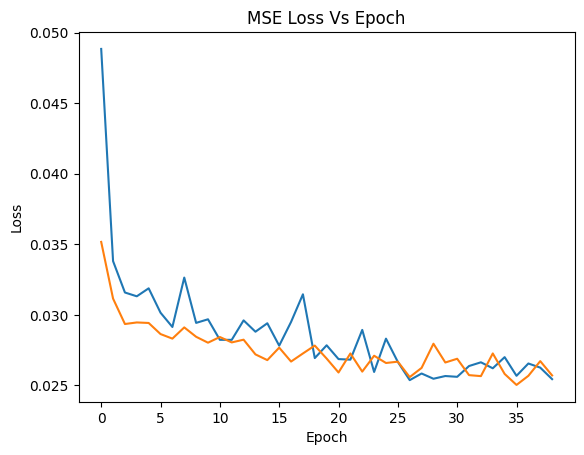

In [320]:
from matplotlib import pyplot as plt
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join("/content/drive/MyDrive/trial", "log2.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])


plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('MSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()